In [158]:
#Import Neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import shutil
import time
from sklearn.metrics import classification_report

### Load Data

In [169]:
train_csv = "/kaggle/input/butterfly-image-classification/Training_set.csv"
train_folder = "/kaggle/input/butterfly-image-classification/train/"

test_csv = "/kaggle/input/butterfly-image-classification/Testing_set.csv"
test_folder = "/kaggle/input/butterfly-image-classification/test/"

## Result path
result_path = f"/kaggle/working/run/"
os.makedirs(result_path, exist_ok=True)

checkpoint_path = os.path.join(result_path, "best_model.keras")
loss_image_path = os.path.join(result_path, 'validation loss.png')
acc_image_path = os.path.join(result_path, 'validation accuracy.png')
confusion_image_path = os.path.join(result_path, 'confusion matrix.png')

In [170]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

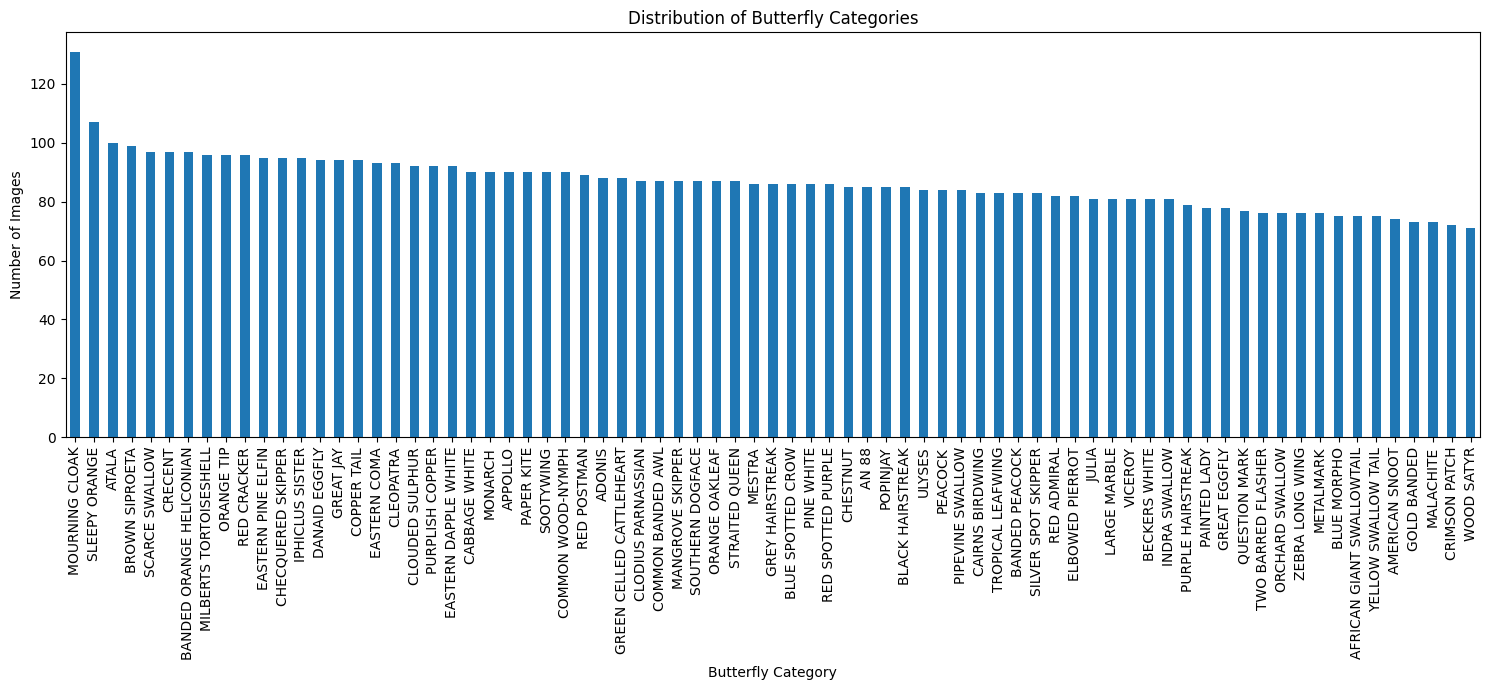

In [171]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [172]:
## Hyperparameter
image_size = (150, 150)
batch_size = 32
epochs = 100
learning_rate = 0.0001


class_name = list(set(train_df['label']))
print(class_name)

['SOUTHERN DOGFACE', 'APPOLLO', 'MONARCH', 'IPHICLUS SISTER', 'POPINJAY', 'RED CRACKER', 'ZEBRA LONG WING', 'PIPEVINE SWALLOW', 'MOURNING CLOAK', 'ADONIS', 'RED POSTMAN', 'ORANGE OAKLEAF', 'TROPICAL LEAFWING', 'PINE WHITE', 'SLEEPY ORANGE', 'GREAT JAY', 'GREY HAIRSTREAK', 'CHECQUERED SKIPPER', 'QUESTION MARK', 'CRIMSON PATCH', 'LARGE MARBLE', 'PAPER KITE', 'MILBERTS TORTOISESHELL', 'JULIA', 'ELBOWED PIERROT', 'ORCHARD SWALLOW', 'EASTERN PINE ELFIN', 'MANGROVE SKIPPER', 'AN 88', 'BLUE MORPHO', 'RED ADMIRAL', 'CABBAGE WHITE', 'BANDED ORANGE HELICONIAN', 'SILVER SPOT SKIPPER', 'SOOTYWING', 'RED SPOTTED PURPLE', 'GREAT EGGFLY', 'MALACHITE', 'GOLD BANDED', 'COMMON BANDED AWL', 'PAINTED LADY', 'CLOUDED SULPHUR', 'PURPLISH COPPER', 'CRECENT', 'PEACOCK', 'SCARCE SWALLOW', 'EASTERN DAPPLE WHITE', 'BLUE SPOTTED CROW', 'BLACK HAIRSTREAK', 'COPPER TAIL', 'YELLOW SWALLOW TAIL', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'BANDED PEACOCK', 'CAIRNS BIRDWING', 'INDRA SWALLOW', 'VICEROY', 'TWO BARRED FLASHER', 

In [173]:
features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    label = class_name.index(label_name)
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [00:33<00:00, 194.41it/s]


In [174]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

6499
6499


In [175]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [176]:
del features
del labels

### ResNet Model

In [177]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 36,714,443 (140.05 MB)

 Trainable params: 36,451,659 (139.05 MB)

 Non-trainable params: 262,784 (1.00 MB)

In [178]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Hitung waktu training
start_time = time.time()

# Latih model dengan menggunakan model checkpoint
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    callbacks=[model_checkpoint, early_stopping],
    batch_size = batch_size,
)

# Hitung waktu training
end_time = time.time()

Epoch 1/100
  1/143 ━━━━━━━━━━━━━━━━━━━━ 2:14:03 57s/step - accuracy: 0.0000e+00 - loss: 11.0454

W0000 00:00:1713320247.747280      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2057 - loss: 8.4580

W0000 00:00:1713320290.931156      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713320295.243376      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713320301.420722      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 112s 388ms/step - accuracy: 0.2069 - loss: 8.4492 - val_accuracy: 0.0318 - val_loss: 8.3332
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.8099 - loss: 4.4982 - val_accuracy: 0.3785 - val_loss: 5.7888
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.9462 - loss: 3.2277 - val_accuracy: 0.6595 - val_loss: 3.9991
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.9672 - loss: 2.6000 - val_accuracy: 0.7097 - val_loss: 3.3273
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.9770 - loss: 2.1231 - val_accuracy: 0.7559 - val_loss: 2.8205
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.9851 - loss: 1.7313 - val_accuracy: 0.7754 - val_loss: 2.4486
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.9963 - loss: 1.4086 - val_accuracy: 0.8051 - val_loss: 2.0910
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9903 - loss: 1.20

In [179]:
print("Training Time", end_time - start_time)

Training Time 696.0854589939117


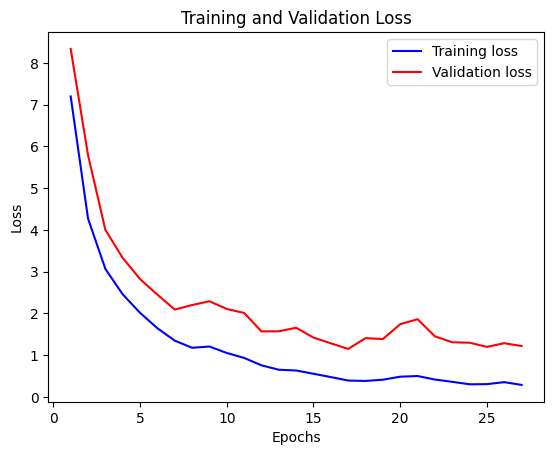

In [180]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(loss_image_path)
plt.show()

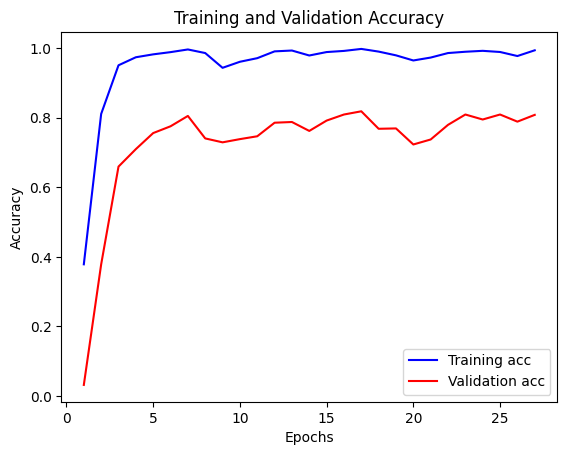

In [181]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(acc_image_path)
plt.show()

In [182]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

W0000 00:00:1713321219.194625      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step
Classification Report:
                            precision    recall  f1-score   support

         SOUTHERN DOGFACE     0.7273    0.7273    0.7273        11
                  APPOLLO     0.9167    0.7333    0.8148        15
                  MONARCH     0.6316    1.0000    0.7742        12
          IPHICLUS SISTER     0.8824    0.9375    0.9091        16
                 POPINJAY     0.9231    1.0000    0.9600        12
              RED CRACKER     0.9231    0.7500    0.8276        16
          ZEBRA LONG WING     1.0000    1.0000    1.0000        10
         PIPEVINE SWALLOW     0.8750    0.8750    0.8750         8
           MOURNING CLOAK     0.8929    0.9259    0.9091        27
                   ADONIS     0.3600    1.0000    0.5294         9
              RED POSTMAN     1.0000    0.7857    0.8800        14
           ORANGE OAKLEAF     1.0000    0.9286    0.9630        14
        TROPICAL LEAFWING     0.7500    0.7059    0.7273       

W0000 00:00:1713321224.154209      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
